In [1]:
import sys
from __future__ import annotations

In [2]:
from pathlib import Path

In [3]:
data_dir = "../benchmark/"

In [4]:
from src.model_clay_eval import CLAYModule
import src.datamodule
#from src.datamodule import ClayDataset, ClayDataModule
from src.datamodule_eval_local import ClayDataset, ClayDataModule
import pandas as pd
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import einops
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import rasterio as rio
from einops import rearrange, reduce
import torch

In [5]:
model = CLAYModule.load_from_checkpoint("../clay-small-70MT-1100T-10E.ckpt", mask_ratio=0.)
model.eval();

In [6]:
model.model.image_size

512

In [7]:
dm = ClayDataModule(data_dir=data_dir, batch_size=4)

In [8]:
dm.setup()

Total number of chips: 19


In [9]:
val_dl = iter(dm.val_dataloader())

In [10]:
batch = next(val_dl)

In [11]:
batch

{'labels': tensor([[[[1., 0., 0.,  ..., 0., 0., 0.],
           [1., 0., 0.,  ..., 0., 0., 0.],
           [1., 1., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 1., 0., 0.],
           [0., 0., 0.,  ..., 1., 1., 0.],
           [0., 0., 0.,  ..., 1., 1., 1.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
     

In [12]:
batch["pixels"] = batch["pixels"].to(model.device)
batch["timestep"] = batch["timestep"].to(model.device)
batch["latlon"] = batch["latlon"].to(model.device)
emb = model.model.encoder(batch)

In [13]:
emb

(tensor([[[-0.0106,  0.0089,  0.0015,  ...,  0.0231, -0.0182,  0.0319],
          [-0.0237,  0.0028, -0.0231,  ..., -0.0307, -0.0166,  0.0023],
          [-0.0145, -0.0421,  0.0089,  ...,  0.0291,  0.0122, -0.0038],
          ...,
          [ 0.0250,  0.0128,  0.0002,  ...,  0.0419,  0.0035,  0.0224],
          [-0.0015, -0.0633,  0.0045,  ..., -0.0067, -0.0514, -0.0048],
          [-0.0137, -0.0402,  0.0031,  ...,  0.0030, -0.0168,  0.0130]]],
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[1517,  502,  350,  ...,  635,  834,  744]]),
 tensor([], size=(1, 0), dtype=torch.int64),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

In [26]:
emb = emb[0]

In [ ]:
emb

In [ ]:
emb[0].shape

In [14]:
# batch = next(val_dl)

# chip = rio.open(batch["path"][2])

# plt.imshow(chip.read(indexes=(3,2,1)).transpose(1,2,0)/1500)

# batch["pixels"] = batch["pixels"].to(model.device)
# batch["timestep"] = batch["timestep"].to(model.device)
# batch["latlon"] = batch["latlon"].to(model.device)

# emb = model.model.encoder(batch)

In [ ]:
from einops import rearrange

embeddings = emb[0]
embeddings = embeddings[:,:-2,:]
latent = rearrange(embeddings, "b (g l) d  -> b g l d", g=6)
latent = rearrange(latent, "b g (h w) d -> b g h w d", h=16, w=16)
latent = rearrange(latent, "b g h w d -> b (g d) h w")
print(latent.shape)


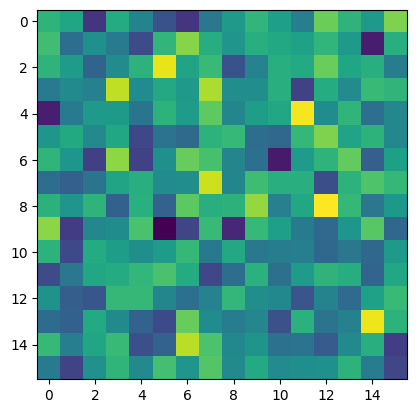

In [19]:
plt.imshow(latent[0][1].detach().numpy())

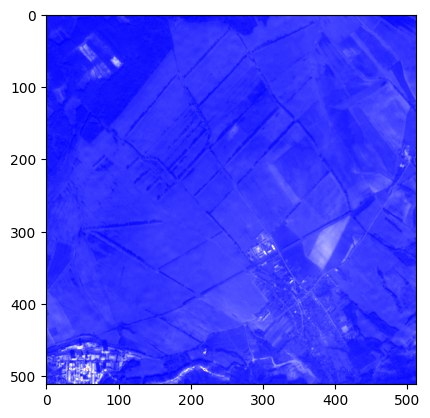

In [26]:
plt.imshow(batch["pixels"][0].permute(1,2,0)[:,:,1].detach().numpy(), cmap="bwr")

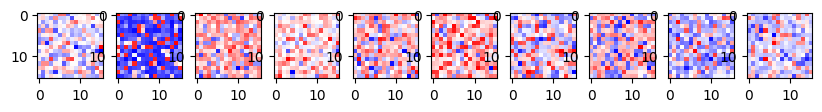

In [24]:
fig, axs = plt.subplots(1,10,figsize=(10,5))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(latent[0][i+10].detach().numpy(), cmap="bwr")

In [28]:
encoder = torch.nn.Sequential(
            torch.nn.Conv2d(4608, 64, kernel_size=1, padding=0),
        )

decoder = torch.nn.Sequential(
    torch.nn.Conv2d(4608, 64, kernel_size=1, padding=0),
    torch.nn.Upsample(scale_factor=2),
    torch.nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Upsample(scale_factor=2),
    torch.nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Upsample(scale_factor=2),
    torch.nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Upsample(scale_factor=2),
    torch.nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1),
    torch.nn.Upsample(scale_factor=2)
)


def forward(x):
    x = decoder(x)
    return x

In [30]:
out = forward(latent)

In [32]:
out.shape

torch.Size([1, 1, 512, 512])

In [7]:
from pytorch_lightning import LightningModule, Trainer
from einops import rearrange

class UNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()        
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Conv2d(4608, 64, kernel_size=1, padding=0),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1),
            torch.nn.Upsample(scale_factor=2)
        )


    def forward(self,x):
        x = self.decoder(x)
        return x


class SegmentationModel(LightningModule):
    def __init__(self, model, datamodule):
        super().__init__()
        self.model = model
        self.datamodule = datamodule
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        print(batch["pixels"].shape, batch["labels"].shape)
        x, y = batch["pixels"], batch["labels"]
        batch["pixels"] = batch["pixels"].to(model_clay.device)
        batch["timestep"] = batch["timestep"].to(model_clay.device)
        batch["latlon"] = batch["latlon"].to(model_clay.device)
        emb = model_clay.model.encoder(batch)
        embeddings = emb[0]
        embeddings = embeddings[:,:-2,:]
        latent = rearrange(embeddings, "b (g l) d  -> b g l d", g=6)
        latent = rearrange(latent, "b g (h w) d -> b g h w d", h=16, w=16)
        latent = rearrange(latent, "b g h w d -> b (g d) h w")
        prediction = self.model(latent)
        print("Prediction shape:", prediction.shape)
        print("Label shape:", y.shape)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(prediction.to(dtype=torch.float32), y)
        loss = torch.tensor(loss, requires_grad=True)
        self.log("train_loss", loss)
        print("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["pixels"], batch["labels"]
        batch["pixels"] = batch["pixels"].to(model_clay.device)
        batch["timestep"] = batch["timestep"].to(model_clay.device)
        batch["latlon"] = batch["latlon"].to(model_clay.device)
        emb = model_clay.model.encoder(batch)
        embeddings = emb[0]
        embeddings = embeddings[:,:-2,:]
        latent = rearrange(embeddings, "b (g l) d  -> b g l d", g=6)
        latent = rearrange(latent, "b g (h w) d -> b g h w d", h=16, w=16)
        latent = rearrange(latent, "b g h w d -> b (g d) h w")
        prediction = self.model(latent)
        print("Prediction shape:", prediction.shape)
        print("Label shape:", y.shape)
        val_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            prediction.to(dtype=torch.float32), y
        )
        val_loss = torch.tensor(val_loss, requires_grad=True)
        print("val_loss", val_loss)
        self.log("val_loss", val_loss)
        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer
    
    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

dm = ClayDataModule(data_dir=data_dir, batch_size=2)
dm.setup()
#val_dl = iter(dm.val_dataloader())

model_unet = UNet(13, 1)
model_clay = CLAYModule.load_from_checkpoint("/Users/lillythomas/Documents/work/clay/lt/benchmark/seg/clay-small-70MT-1100T-10E.ckpt", mask_ratio=0.)
model_clay.eval();
segmentation_model = SegmentationModel(model_unet, dm)

trainer = Trainer(max_epochs=3)
trainer.fit(segmentation_model)

Total number of chips: 19
Epoch 0:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 8/10 [05:49<01:27, 43.70s/it, loss=0, v_num=6]

                                                                                                                                                                                                            

Traceback (most recent call last):
  File "/Users/lillythomas/.pyenv/versions/3.8.6/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/Users/lillythomas/.pyenv/versions/3.8.6/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/Users/lillythomas/.pyenv/versions/3.8.6/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 319 K 
-------------------------------
319 K     Trainable params
0         Non-trainable params
319 K     Total params
1.277     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                                                                                                                                   | 0/2 [00:00<?, ?it/s]torch.Size([2, 1538, 768])
torch.Size([2, 1, 512, 512])
Prediction shape: torch.Size([2, 1, 512, 512])
Label shape: torch.Size([2, 1, 512, 512])
val_loss tensor(0.7568, requires_grad=True)
Sanity Checking DataLoader 0:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 1/2 [00:10<00:10, 10.80s/it]

/var/folders/wz/qvnrzvw92_zfzw3lmwsf1mjh0000gn/T/ipykernel_5796/3711461558.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = torch.tensor(val_loss, requires_grad=True)


torch.Size([2, 1538, 768])
torch.Size([2, 1, 512, 512])
Prediction shape: torch.Size([2, 1, 512, 512])
Label shape: torch.Size([2, 1, 512, 512])
val_loss tensor(0.7269, requires_grad=True)
Epoch 0:   0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]torch.Size([2, 13, 512, 512]) torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
Prediction shape: torch.Size([2, 1, 512, 512])
Label shape: torch.Size([2, 1, 512, 512])
train_loss tensor(0.7615, requires_grad=True)


/var/folders/wz/qvnrzvw92_zfzw3lmwsf1mjh0000gn/T/ipykernel_5796/3711461558.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss, requires_grad=True)


Epoch 0:  10%|█████████████▊                                                                                                                            | 1/10 [00:22<03:19, 22.19s/it, loss=0.762, v_num=6]torch.Size([2, 13, 512, 512]) torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
Prediction shape: torch.Size([2, 1, 512, 512])
Label shape: torch.Size([2, 1, 512, 512])
train_loss tensor(0.6804, requires_grad=True)
Epoch 0:  20%|███████████████████████████▌                                                                                                              | 2/10 [00:33<02:14, 16.84s/it, loss=0.721, v_num=6]torch.Size([2, 13, 512, 512]) torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
Prediction shape: torch.Size([2, 1, 512, 512])
Label shape: torch.Size([2, 1, 512, 512])
train_loss tensor(0.7580, requires_grad=True)
Epoch 0:  30%|█████████████████████████████████████████▍                                                                                          

Epoch 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8/10 [02:19<00:34, 17.48s/it, loss=0.738, v_num=6]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]torch.Size([2, 1538, 768])
torch.Size([2, 1, 512, 512])
Prediction shape: torch.Size([2, 1, 512, 512])
Label shape: torch.Size([2, 1, 512, 512])
val_loss tensor(0.7568, requires_grad=True)

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9/10 [02:49<00:18, 18.81s/it, loss=0.738, v_num=6]torch.Size([2, 1538, 768])
torch.Size([2, 1, 512, 512])
Prediction shape: torch.Size([2, 1, 512, 512])
Label shape: torch.Size([2, 1, 512, 512])
val_loss tensor(0.726

In [ ]:
next(iter(dm.train_dataloader()))["pixels"].shape

In [ ]:
def plot_predictions(model, model_clay, dataloader):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            #print(batch)
            x_val, y_val = batch["pixels"], batch["labels"]
            
            emb = model_clay.model.encoder(batch)
            embeddings = emb[0]
            embeddings = embeddings[:,:-2,:]
            latent = rearrange(embeddings, "b (g l) d  -> b g l d", g=6)
            latent = rearrange(latent, "b g (h w) d -> b g h w d", h=16, w=16)
            latent = rearrange(latent, "b g h w d -> b (g d) h w")
            prediction = model(latent)
            sig = torch.nn.Sigmoid()
            prediction = sig(prediction)
            _, prediction = torch.max(prediction, dim=1)

            # Convert tensors to NumPy arrays for plotting
            x_val_np = x_val.cpu().numpy()
            y_val_np = y_val.cpu().numpy()
            prediction_np = prediction.cpu().numpy()

            # Plot images and masks
            num_samples = min(4, len(x_val))  # Number of samples to visualize
            fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))

            for i in range(num_samples):
                print(np.unique(prediction_np[i]))
                axes[i, 0].imshow(
                    np.transpose(
                        np.stack(
                            (
                                x_val_np[i][2, :, :],
                                x_val_np[i][1, :, :],
                                x_val_np[i][0, :, :],
                            )
                        ),
                        (1, 2, 0),
                    )
                )  # Plot input images
                axes[i, 1].imshow(
                    np.transpose(y_val_np[i], (1, 2, 0))
                )  # Plot ground truths
                axes[i, 2].imshow(prediction_np[i].squeeze())  # Plot model predictions

            plt.show()

model_clay = CLAYModule.load_from_checkpoint("/Users/lillythomas/Documents/work/clay/lt/benchmark/seg/clay-small-70MT-1100T-10E.ckpt", mask_ratio=0.)
model_clay.eval()
#val_dataloader = datamodule_floods.val_dataloader()
plot_predictions(model_unet, model_clay, dm.val_dataloader())
